In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy.stats import binned_statistic_2d
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P


##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [54]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    year = np.array(dic['year'])[mask]
    
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)


    thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tlow, 'K')
    q = units.Quantity(qq, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
    thetae = thetae_down - thetaes_up
    thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
       # 'pall' : pall,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,     
        'year' : year,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [55]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax'])
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
    tgrad = np.array(dic['tgrad'])
    tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    pall = np.array(dic['p'])
    year = np.array(dic['year'])

    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup+273.15, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

    thetaes_up = np.array(thetaes_up)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tsrfc+273.15, 'K')
    q = units.Quantity(qq/1000, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
    thetaes = thetaes_down-thetaes_up  
    thetae = thetae_down -thetaes_up  
#     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp,
    #    'pall' : pall,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
        'tgrad' : tgrad,
        'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'year' : year,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'theta_es' : thetaes
    } 

#     try:
    obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [56]:
ttag = 'hourly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [57]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [58]:
obs_gpmf.head()

,prcp,q925,q650,t925,shear,month,year,area,tmin,rh,theta_e,theta_es,tcwv,tgrad,tbox,lat,lon
0,33.945941,16.032429,5.258263,21.451288,21.597702,9,2008,6350,-80.861286,92.476395,5.352094,9.537061,50.086918,0.174528,3.371307,15.337195,-11.309676
1,4.216382,13.945688,6.594621,21.226892,-3.408928,8,2008,9500,-66.841842,80.737831,0.152769,10.020525,47.465511,0.115285,0.348175,11.320022,-12.558099
2,59.185143,14.722182,4.939521,24.223535,20.380962,7,2008,109950,-84.518429,71.706879,4.475381,23.200466,46.883617,0.169490,4.454224,15.367470,-12.196891
3,2.248306,17.130347,6.434912,21.410577,18.177017,8,2008,19025,-69.398859,99.019821,13.786762,14.390733,59.113689,0.239586,0.140045,17.328758,-12.240657
4,43.297786,16.088208,5.281735,27.334863,20.113298,6,2008,190925,-88.485493,65.269966,13.391944,42.317307,48.521294,0.178521,4.899445,11.785741,6.625053


In [59]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
9.000161827841007
12.107882421128927
-14.998084590200353


In [60]:
tag = 'Sahel'
domainSA = [-12,15,5,8.5]
domainSS = [-12,12,9,18]  # 8.5, 17.5
domainWA = [-17,15,4,25]
domainOuaga = [-3.5,2,11,13.5]
nb = 25
region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(5,21,nb), np.linspace(-7.9,7.9,nb), np.linspace(29,75,nb)],  #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(6,20,nb), np.linspace(-7.9,7.9,nb), np.linspace(29,80,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-7.9,6,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-7.9,7.9,nb), np.linspace(20,92,nb)],
         }

domain = region[tag][0]
tname = region[tag][1]

m1 = 5 #5
m2 = 10 #10
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2) ] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [61]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 9.008251190185547 17.99925422668457 -11.76275634765625 11.990509033203125
OBS_gpm 9.000161827841007 17.74562661158754 -11.996923725377139 11.996942654145766


In [62]:
len(obs_gpm)

29392

Text(0.5, 1.0, '0.14')

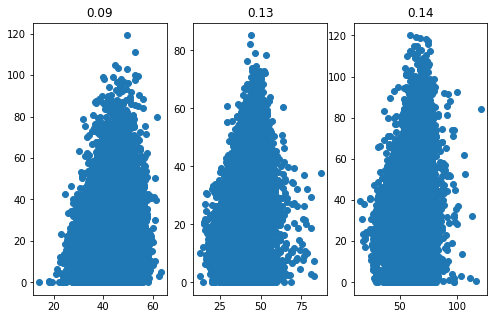

In [63]:

cp4s = [obs_gpm.tcwv, obs_gpm.prcp] # gpm
cp25s = [hist.tcwv, hist.prcp] #cp4
futur = [fut.tcwv, fut.prcp] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [64]:
oposi =  (obs_gpm.q925>=8.) & (obs_gpm.prcp>=0.1) & (obs_gpm.theta_e>=-40) & (obs_gpm.area>=5000) & (obs_gpm.shear>0) & (obs_gpm.tmin<=-55)  # & ((obs_gpm.month>=9) | (obs_gpm.month<=5)) #(obs_gpm.q925>=9.) & (obs_gpm.shear>-5) & 
cposi =   (hist.q925>=8.) &(hist.prcp>=0.1)  & (hist.theta_e>=-40) & (np.isfinite(hist.q925)) & (hist.shear>0)  & (hist.area>=5000) & (hist.tmin<=-55)  #(hist.q925>=9.) & (hist.shear>-5) &
fposi =  (fut.q925>=8.) &(fut.prcp>=0.1)  & (fut.theta_e>=-40) & (np.isfinite(fut.q925)) & (fut.shear>0)  & (fut.area>=5000) & (fut.tmin<=-55)   #(fut.q925>=9.) & (fut.shear>-5) & 

In [65]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

/home/ck/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [66]:
np.min(obs.prcp)

0.10022597130925144

In [67]:
# import pickle
# pickle.dump(obs, open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "wb"))
# pickle.dump(cp4, open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "wb"))
# pickle.dump(cp4f, open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "wb"))

In [68]:
base = '/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/'

dics = ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut']
cp4_read = {'period' : [], 'shear' : [], 'tcwv' : []}
for dd in dics:
   
    dic = pd.read_csv(base+dd+'_vars_DAILY.csv', index_col=0)
    #ipdb.set_trace()
    cp4_read['period'].append(dd)
    cp4_read['shear'].append(np.array(dic.loc['shear'])*-1)
    cp4_read['tcwv'].append(np.array(dic.loc['tcwv']))
cp4_df = pd.DataFrame.from_dict(cp4_read)
cp4_df = cp4_df.set_index('period')
cp4_shear_diff = (cp4_df.loc['CP4fut', 'shear']-cp4_df.loc['CP4hist', 'shear'])#/cp4_df.loc['CP4hist', 'shear']*100
cp25_shear_diff = (cp4_df.loc['CP25fut', 'shear']-cp4_df.loc['CP25hist', 'shear'])#/cp4_df.loc['CP25hist', 'shear']*100

cp4_tcwv_diff = (cp4_df.loc['CP4fut', 'tcwv']-cp4_df.loc['CP4hist', 'tcwv'])#/cp4_df.loc['CP4hist', 'tcwv']*100
cp25_tcwv_diff = (cp4_df.loc['CP25fut', 'tcwv']-cp4_df.loc['CP25hist', 'tcwv'])#/cp4_df.loc['CP25hist', 'tcwv']*100
cp4_tcwv_hist = cp4_df.loc['CP4hist', 'tcwv']

In [69]:
cp4_tcwv_hist

array([40.874004])

In [70]:
obs.area.min()

5225

In [71]:
len(obs)

28614

In [72]:
len(cp4)

57179

In [73]:
len(cp4f)

42328

In [74]:
print(np.mean(cp4.tcwv))

43.19003327770073


In [75]:
np.percentile(cp4f.tcwv,0.01)

26.753549145117297

In [76]:
print(np.mean(cp4f.shear))

16.757975958263305


In [77]:
obs_basic = hist2d.basic_1d_binning(obs['tcwv'], np.arange(np.min(obs['tcwv']), np.max(obs['tcwv']),1))
cp4_basic = hist2d.basic_1d_binning(cp4['tcwv'], np.arange(np.min(cp4['tcwv']), np.max(cp4['tcwv']),1))
cp4f_basic = hist2d.basic_1d_binning(cp4f['tcwv'], np.arange(np.min(cp4f['tcwv']), np.max(cp4f['tcwv']),1))

In [78]:
obs_basic_shear = hist2d.basic_1d_binning(obs['shear'], np.arange(np.min(obs['shear']), np.max(obs['shear']),1))
cp4_basic_shear = hist2d.basic_1d_binning(cp4['shear'], np.arange(np.min(cp4['shear']), np.max(cp4['shear']),1))
cp4f_basic_shear = hist2d.basic_1d_binning(cp4f['shear'], np.arange(np.min(cp4f['shear']), np.max(cp4f['shear']),1))

In [79]:
obs_basic_pr = hist2d.basic_1d_binning(obs['prcp'], np.arange(np.min(obs['prcp']), np.max(obs['prcp']),1))
cp4_basic_pr = hist2d.basic_1d_binning(cp4['prcp'], np.arange(np.min(cp4['prcp']), np.max(cp4['prcp']),1))
cp4f_basic_pr = hist2d.basic_1d_binning(cp4f['prcp'], np.arange(np.min(cp4f['prcp']), np.max(cp4f['prcp']),1))

In [80]:
obs_basic_tmin = hist2d.basic_1d_binning(obs['tmin'], np.arange(np.min(obs['tmin']), np.max(obs['tmin']),1))
cp4_basic_tmin = hist2d.basic_1d_binning(cp4['tmin'], np.arange(np.min(cp4['tmin']), np.max(cp4['tmin']),1))
cp4f_basic_tmin = hist2d.basic_1d_binning(cp4f['tmin'], np.arange(np.min(cp4f['tmin']), np.max(cp4f['tmin']),1))

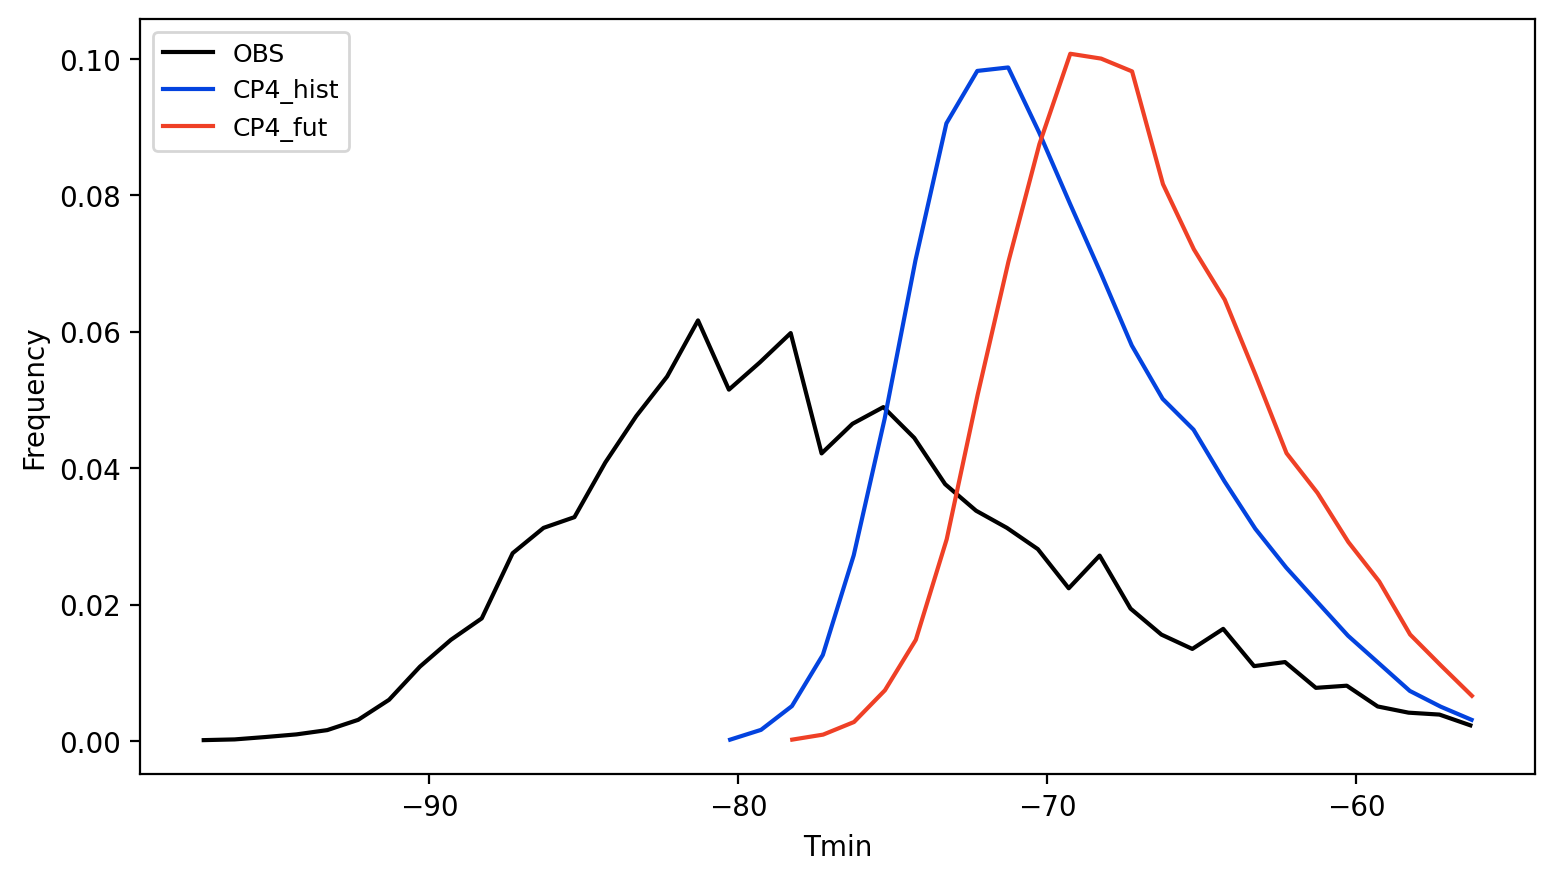

In [81]:
f = plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)
plt.plot(obs_basic_tmin['xbins'], obs_basic_tmin['nb']/np.sum(obs_basic_tmin['nb']), label='OBS', color='k')
plt.plot(cp4_basic_tmin['xbins'], cp4_basic_tmin['nb']/np.sum(cp4_basic_tmin['nb']), color='xkcd:blue', label='CP4_hist')
plt.plot(cp4f_basic_tmin['xbins'], cp4f_basic_tmin['nb']/np.sum(cp4f_basic_tmin['nb']), color='xkcd:tomato', label='CP4_fut')
plt.ylabel('Frequency')
plt.xlabel('Tmin')
#ax.set_xlim(-8,32)
plt.legend(loc='upper left', fontsize=9)

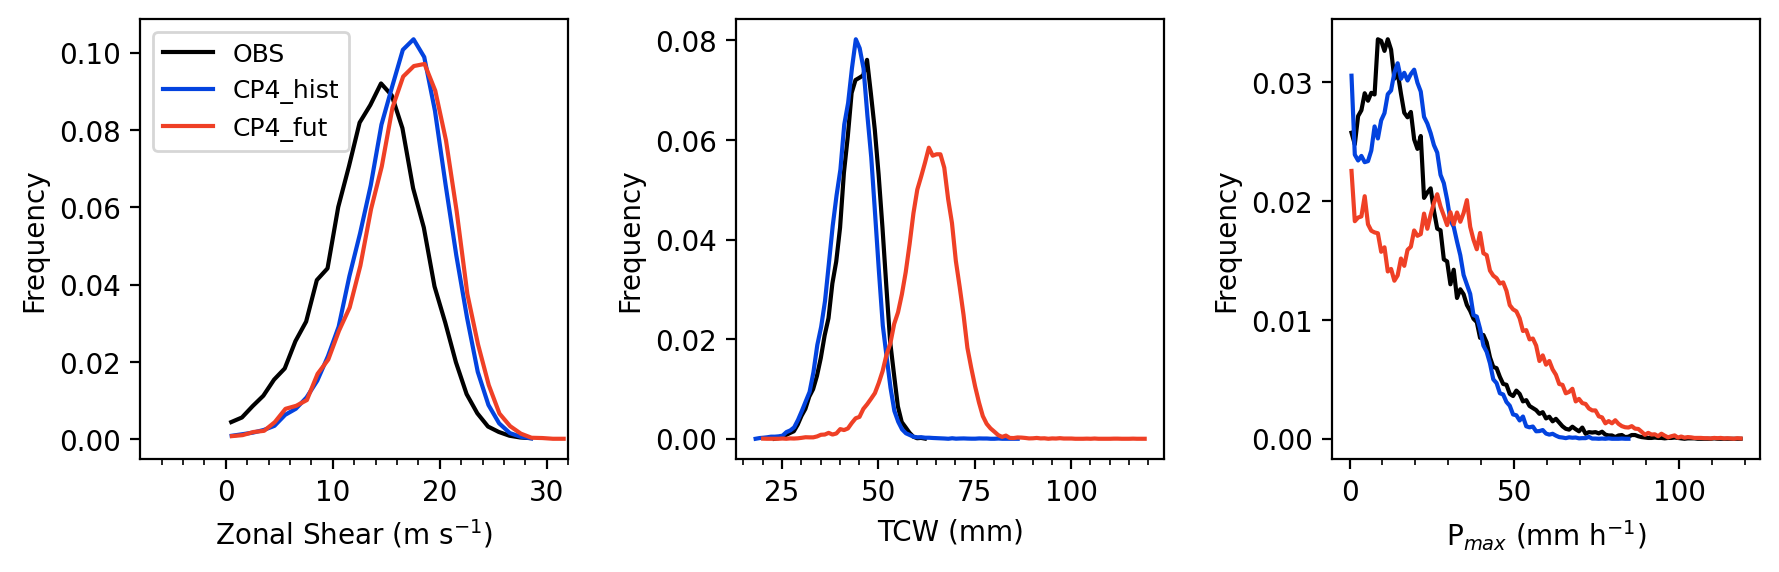

In [82]:
f = plt.figure(figsize=(9,3), dpi=200)
ax = f.add_subplot(131)
plt.plot(obs_basic_shear['xbins'], obs_basic_shear['nb']/np.sum(obs_basic_shear['nb']), label='OBS', color='k')
plt.plot(cp4_basic_shear['xbins'], cp4_basic_shear['nb']/np.sum(cp4_basic_shear['nb']), color='xkcd:blue', label='CP4_hist')
plt.plot(cp4f_basic_shear['xbins'], cp4f_basic_shear['nb']/np.sum(cp4f_basic_shear['nb']), color='xkcd:tomato', label='CP4_fut')
plt.ylabel('Frequency')
plt.xlabel('Zonal Shear (m s$^{-1}$)')
ax.set_xlim(-8,32)
plt.legend(loc='upper left', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')
# for xx in range(5,26,5):
#     plt.axvline(xx, linestyle='dashed', color='slategrey', linewidth=0.5)
ax = f.add_subplot(132)
plt.plot(obs_basic['xbins'], obs_basic['nb']/np.sum(obs_basic['nb']), label='OBS', color='k')
plt.plot(cp4_basic['xbins'], cp4_basic['nb']/np.sum(cp4_basic['nb']), color='xkcd:blue', label='CP4_hist')
plt.plot(cp4f_basic['xbins'], cp4f_basic['nb']/np.sum(cp4f_basic['nb']), color='xkcd:tomato', label='CP4_fut')
plt.ylabel('Frequency')
plt.xlabel('TCW (mm)')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(133)
plt.plot(obs_basic_pr['xbins'], obs_basic_pr['nb']/np.sum(obs_basic_pr['nb']), label='OBS', color='k')
plt.plot(cp4_basic_pr['xbins'], cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb']), color='xkcd:blue', label='CP4_hist')
plt.plot(cp4f_basic_pr['xbins'], cp4f_basic_pr['nb']/np.sum(cp4f_basic_pr['nb']), color='xkcd:tomato', label='CP4_fut')
plt.ylabel('Frequency')
plt.xlabel('P$_{max}$ (mm h$^{-1}$)')
# ax1 = ax.twinx()
# ax1.plot(cp4_basic_pr['xbins'], (np.array(cp4f_basic_pr['nb']/np.sum(cp4f_basic_pr['nb']))[0:80]-(cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb'])))/(cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb'])))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

#plt.xlim(19,80)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/distribution_'+tag+'_OBS_CP4_driver_'+ttag+'_percentile_0.1mm.png')

In [230]:
def get_percentile(x):

    ptag = [0.1]+list(np.arange(5,96,5))+[99.9]
    return np.percentile(x[np.isfinite(x)], ptag) 

In [231]:
def hist_2d(datax, datay, data, func, bins=None):
    
    countfunc = lambda y: np.sum(np.isfinite(y))
    
    ret = binned_statistic_2d(datax, datay, data, statistic=func, bins=bins)
    count = binned_statistic_2d(datax, datay, data, statistic=countfunc, bins=bins)
    
    return ret.statistic.T, count.statistic.T, bins

In [232]:
def apply_2d(dic, var, varx, vary, func):
    
    xbins = get_percentile(dic[varx])
    ybins = get_percentile(dic[vary])
    
#     print('xbins', xbins)
#     print('ybins', ybins)
    
    bins = [xbins, ybins]
    
    ret, count, obin = hist_2d(dic[varx], dic[vary], dic[var], func, bins=bins)
    return ret, count, obin
    
    

In [233]:
obs.groupby('year').max()

,prcp,q925,q650,t925,shear,month,area,tmin,rh,theta_e,theta_es,tcwv,tgrad,tbox,lat,lon
year,,,,,,,,,,,,,,,,
2004,103.391803,18.319480,8.361171,34.090692,26.137394,10,612100,-55.000000,100.940308,20.506504,86.023295,60.573341,0.370698,9.526154,17.695947,11.958954
2005,100.256116,18.230630,8.602174,35.526819,27.823326,10,591150,-55.299574,100.395950,19.589251,100.034196,60.264442,0.369639,9.302979,17.652523,11.928885
2006,98.186602,18.321153,8.359582,34.544031,26.470539,10,533950,-55.000000,100.575897,20.904334,89.682227,61.623417,0.336121,8.653900,17.649484,11.942982
2007,91.678972,18.329507,8.758880,34.925470,27.365725,10,563950,-55.055665,100.789284,23.058324,92.232625,59.547985,0.332921,9.598846,17.683389,11.938233
2008,96.697656,18.758889,9.084560,34.038660,26.504564,10,591325,-55.000000,100.532928,19.482308,89.198220,62.613831,0.351232,9.044952,17.703685,11.992226
2009,86.844578,18.348757,8.698839,34.149500,29.890968,10,580275,-55.000000,99.983902,18.981600,88.868922,59.532974,0.358361,8.944702,17.635734,11.943892
2010,103.028118,18.293481,9.211610,36.102502,25.954166,10,569575,-55.000000,100.817657,18.587384,105.827285,61.132729,0.330325,9.267853,17.668874,11.960518
2011,119.135393,17.877020,8.569518,37.169336,27.064768,10,475175,-55.000000,100.437439,20.962003,116.786714,61.037254,0.331391,8.765961,17.721738,11.936241
2012,104.700587,18.837478,8.906051,34.208459,26.950567,10,752425,-55.000000,101.927277,21.779311,92.317155,57.877090,0.338479,9.002533,17.690434,11.996943


In [234]:
func = lambda y: np.percentile(y, 95)

ret_obs, count_obs, bins_obs = apply_2d(obs, 'prcp', 'shear', 'tcwv', func)
ret_cp4, count_cp4, bins_cp4 = apply_2d(cp4, 'prcp', 'shear', 'tcwv', func)
ret_cp4f, count_cp4f, bins_cp4f = apply_2d(cp4f, 'prcp', 'shear', 'tcwv', func)

In [235]:
vlist=['prcp']
obs_tcwv = hist2d.create_2dhist_maxYear(obs.shear, obs.tcwv, get_percentile(obs.shear), get_percentile(obs.tcwv), obs, vlist)
cp4_tcwv = hist2d.create_2dhist_maxYear(cp4.shear, cp4.tcwv, get_percentile(cp4.shear), get_percentile(cp4.tcwv), cp4, vlist)
cp4f_tcwv = hist2d.create_2dhist_maxYear(cp4f.shear, cp4f.tcwv, get_percentile(cp4f.shear), get_percentile(cp4f.tcwv), cp4f, vlist)

In [236]:
obs_tcwv.keys()

dict_keys(['prcp', 'prcp_val', 'prcp_std', 'xbins', 'ybins'])

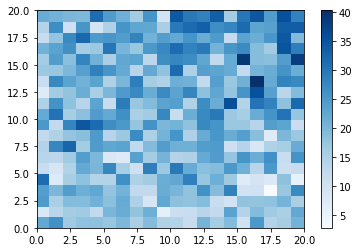

In [237]:
plt.pcolormesh((cp4f_tcwv['prcp']-cp4_tcwv['prcp']), cmap='Blues')
plt.colorbar()


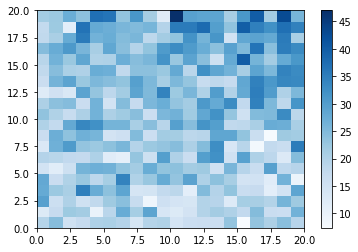

In [238]:
plt.pcolormesh(ret_cp4f-ret_cp4, cmap='Blues')
plt.colorbar()

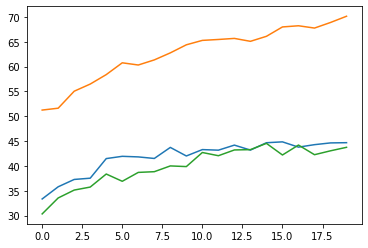

In [239]:
plt.plot(np.nanmean(cp4_tcwv['prcp'], axis=1))
plt.plot((cp4f_tcwv['prcp']).mean(axis=1))
plt.plot((obs_tcwv['prcp']).mean(axis=1))

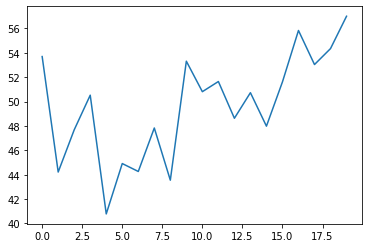

In [240]:
percent = ((cp4f_tcwv['prcp']).mean(axis=1)-(cp4_tcwv['prcp']).mean(axis=1))/(cp4_tcwv['prcp']).mean(axis=1)*100
plt.plot(percent)

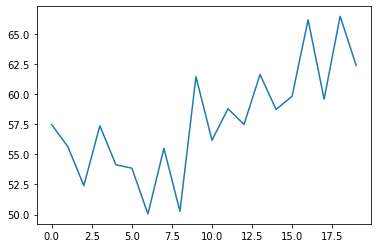

In [241]:
percent = (ret_cp4f.mean(axis=1)-ret_cp4.mean(axis=1))/ret_cp4.mean(axis=1)*100
plt.plot(percent)

In [242]:
def run_binning(data, count, bins, axis=0):
    
    dd = data    
#     invalid = count < 2
#     dd[invalid] = np.nan
    
    mean = np.nanmean(dd,axis=axis)
    val = np.nansum(np.isfinite(dd),axis=axis)
    
    #mean[val<3] = np.nan
    #ipdb.set_trace()
    perc = np.nanpercentile(dd, [10,90], axis=axis)
    #perc[np.where(np.isnan(mean))]=np.nan
    sbin = bins[axis]
    bins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    
    odic = {
        'pmean' :mean,
        'p90' : perc[0],
        'p10' : perc[1],
        'rbins' : bins,
    }
    
    return odic

In [243]:
# obs_tcwv_shear = run_binning(ret_obs, count_obs, bins_obs, axis=0)
# cp4_tcwv_shear = run_binning(ret_cp4, count_cp4, bins_cp4, axis=0)
# cp4f_tcwv_shear = run_binning(ret_cp4f, count_cp4f, bins_cp4f, axis=0)

# obs_shear_tcwv = run_binning(ret_obs, count_obs, bins_obs, axis=1)
# cp4_shear_tcwv = run_binning(ret_cp4, count_cp4, bins_cp4, axis=1)
# cp4f_shear_tcwv = run_binning(ret_cp4f, count_cp4f, bins_cp4f, axis=1)

In [244]:

cp4_tcwv_shear = run_binning(cp4_tcwv['prcp'], cp4_tcwv['prcp_val'], [cp4_tcwv['xbins'],cp4_tcwv['ybins']], axis=0)
cp4f_tcwv_shear = run_binning(cp4f_tcwv['prcp'], cp4f_tcwv['prcp_val'], [cp4f_tcwv['xbins'],cp4f_tcwv['ybins']], axis=0)

cp4_shear_tcwv = run_binning(cp4_tcwv['prcp'], cp4_tcwv['prcp_val'], [cp4_tcwv['xbins'],cp4_tcwv['ybins']], axis=1)
cp4f_shear_tcwv = run_binning(cp4f_tcwv['prcp'], cp4f_tcwv['prcp_val'], [cp4f_tcwv['xbins'],cp4f_tcwv['ybins']], axis=1)

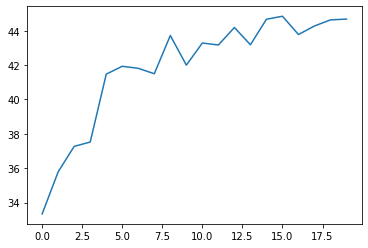

In [245]:
plt.plot(cp4_shear_tcwv['pmean'])

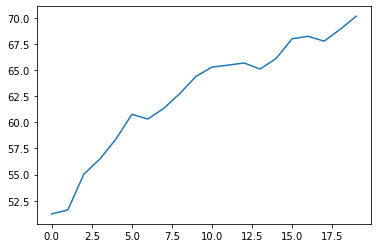

In [246]:
plt.plot(cp4f_shear_tcwv['pmean'])

In [247]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip_read = {}
for dd in dics:
    cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP.csv', index_col='model_name')

In [248]:
cmip_read

{'2030':                 Unnamed: 0  shear_mean  tcw_mean   tcw_hist  shear_hist
 model_name                                                             
 CESM1-CAM5               0    0.192879  5.219648  42.785386   14.220584
 CESM1-BGC                1    0.376596  4.703873  37.317704   13.081765
 GISS-E2-R-CC             2    0.928010  4.733266  42.508641   14.398726
 IPSL-CM5A-LR             3    0.595817  6.462611  30.821191   12.744528
 GFDL-ESM2M               4    0.099754  4.909838  42.941644    8.922368
 NorESM1-M                5    1.368096  5.025928  32.124699   10.046895
 MPI-ESM-LR               6    1.049326  5.767301  40.817246   13.602209
 HadGEM2-CC               7    2.041470  6.879838  29.608423   10.080733
 GISS-E2-R                8    0.777508  4.785330  42.511328   14.544476
 HadGEM2-ES               9    1.921261  7.287217  30.406853   10.186812
 ACCESS1-3               10    0.916450  6.405697  30.507245    4.134330
 FGOALS-g2               11    0.376314  4.

In [249]:
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv

In [250]:
percmid = np.arange(0,101,5)
percents = percmid[0:-1] + (percmid[1::]-percmid[0:-1])/2

Scaling per percentile [1.2020507  0.96264781 1.02696191 1.08463634 0.87663878 0.97279012
 0.96774788 1.05436339 0.96605364 1.18907076 1.13740995 1.15704903
 1.09253993 1.14356634 1.08517973 1.17223274 1.2728821  1.21424277
 1.25345739 1.37187039]
Percentage median 1.1149749390444987
Percentage abs  1.067937074277687


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Text(0, 4, 'b')

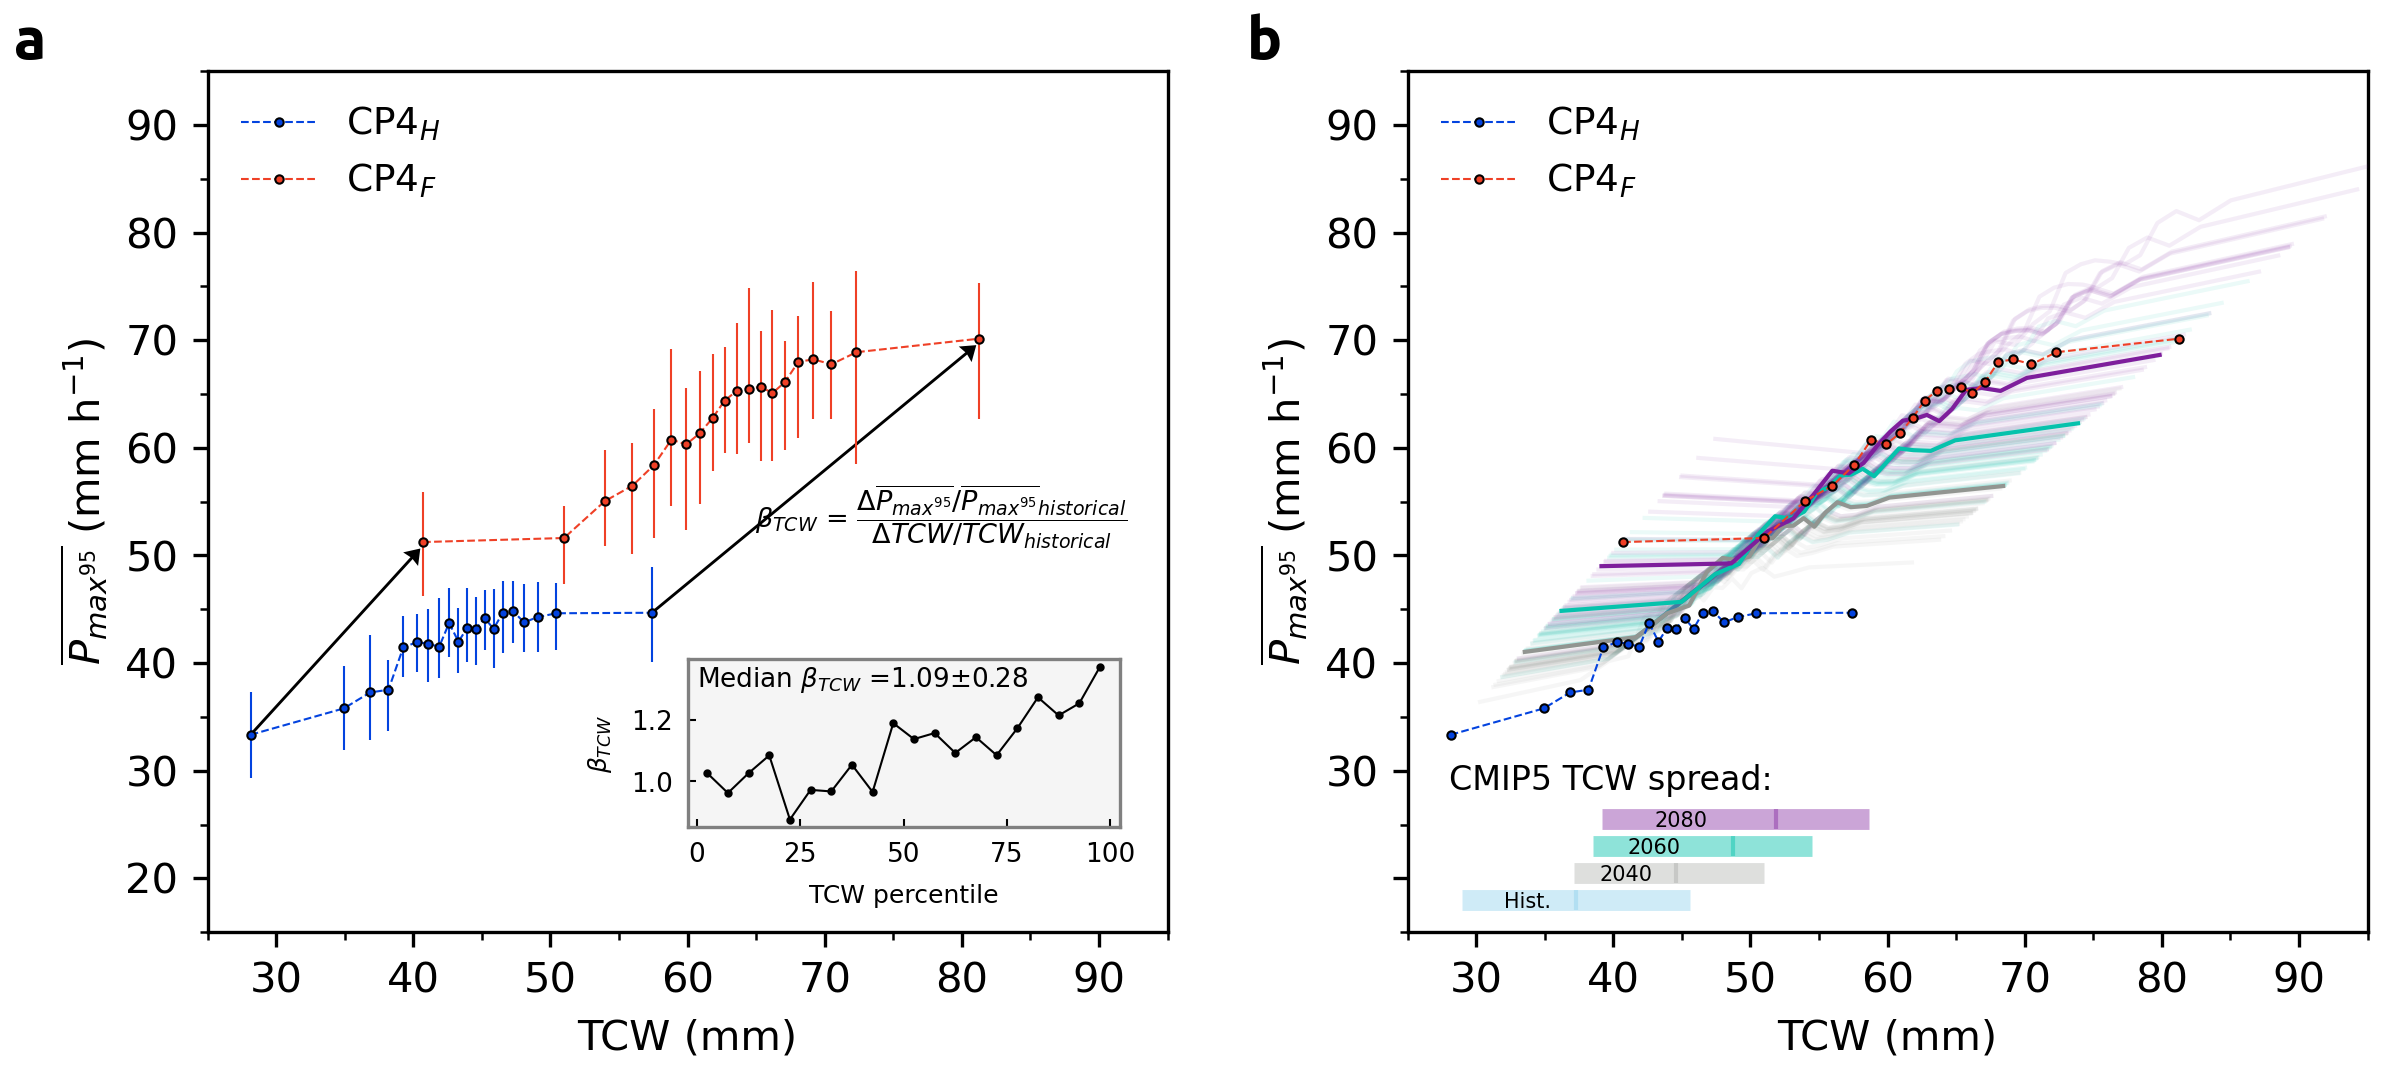

In [251]:
f = plt.figure(figsize=(8,3.5), dpi=300)
widthnorm = 0.40
heightnorm = 0.82
bottomnorm=0.13

left, bottom, width, height = [0.58, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [10.5,13,15.5]
alphas = [0.3,0.45,0.4]
ccolors = ['xkcd:grey', 'xkcd:turquoise', 'xkcd:purple']
dy = 10

#####
spread = ((cmip_read['2040'])['tcw_hist'])
mins = np.min(spread)
maxs = np.max(spread)
median = np.median(spread)
#ipdb.set_trace()
ax.errorbar(np.array(median), np.array(8+dy), xerr=np.array([[median-mins, maxs-median]]).T, color='skyblue', linewidth=5, alpha=0.4, linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)
idss=0
for ids, stry in enumerate(['2040', '2060', '2080']):
    idss += idss+1
    ##########
    spread = ((cmip_read[stry])['tcw_mean'])+((cmip_read[stry])['tcw_hist'])
    mins = np.min(spread)
    maxs = np.max(spread)
    median = np.median(spread)
    #ipdb.set_trace()
    ax.errorbar(np.array(median), np.array(posis[ids]+dy), xerr=np.array([[median-mins, maxs-median]]).T, color=ccolors[ids], linewidth=5, alpha=alphas[ids], linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)

ax.spines['top'].set_visible(True)
ax.spines['top'].set_linewidth(0.8)


ax.text(28,18.25+dy,'CMIP5 TCW spread:', fontsize=8)
ax.text(32,7.25+dy,'Hist.', fontsize=5)
ax.text(39,9.75+dy,'2040', fontsize=5)
ax.text(41,12.25+dy,'2060', fontsize=5)
ax.text(43,14.75+dy,'2080', fontsize=5)
####

# ax.plot(pcp4['rbins'],pcp4['pmean'], color='mediumblue',  label=r'CP4 historical', linestyle='',marker='o', markersize=3)  #marker='o', markersize=1, #cornflowerblue
# ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', label=r'CP4 future', linestyle='',marker='o', markersize=3) #, marker='o', markersize=1


histline = np.array(pcp4['pmean']) #np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept']))
futline = np.array(pcp4f['pmean']) #np.array(pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])

ax.plot(pcp4['rbins'],histline, color='xkcd:blue', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4$_H$', mfc='xkcd:blue',  marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)
ax.plot(pcp4f['rbins'], futline, color='xkcd:tomato', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4$_F$', mfc='xkcd:tomato', marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)


pick = np.array([0,-1])
ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_yticklabels(['','',30,40,50,60,70,80,90])
ax.legend(loc='upper left', frameon=False, fontsize=9)
coll = []
abss = []
collmm = []

for ids, percs in enumerate(percents):

    ppabs = (futline[ids]-histline[ids])/(pcp4f['rbins'][ids]-pcp4['rbins'][ids])

    aprcp = (futline[ids]-histline[ids])/histline[ids]
    btcw = (pcp4f['rbins'][ids]-pcp4['rbins'][ids])/pcp4['rbins'][ids]
    pperc = aprcp/btcw
    coll.append(pperc)

    abss.append(ppabs)
    
coll = np.array(coll)
abss = np.array(abss)


        
print('Scaling per percentile', coll)
    
for yyinds, yy in enumerate(['2040', '2060', '2080']):
    cmip_rrel = []
    cmip_rel = (cmip_read[yy]['tcw_mean'])/(cmip_read[yy]['tcw_hist'])  #cp4_historical_domainMean #/np.mean(cp4.tcwv)# relative to average MCS tcw ; i.e. if this is the change that ocurrs relative to MCS baseline tcw / compares domain-wide aggregate to domain-wide aggregate
    for crbins in (cmip_read[yy]['tcw_mean']):
        cmip_rrel.append(crbins/np.array(pcp4['rbins']))
    
    cmip_rrel = np.array(cmip_rrel)
    #ipdb.set_trace()
        
    cmip_diff = (cmip_read[yy]['tcw_mean'])
 
    for cinds, cmip_di in enumerate(cmip_rel):
        cmipfut = np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*cmip_di
        cmean = histline+histline*(cmip_di)*coll
        ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

        
#     for cinds, cmip_di in enumerate(cmip_read[yy]['tcw_mean']):
#         cmipfut = np.array(pcp4['rbins'])+cmip_di
#         cmean = histline+np.array(coll)*(cmip_di) 
#         ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

    cmean = histline+histline*(np.mean(cmip_rel))*coll #

    ax.plot(np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*np.mean(cmip_rel), cmean, color=ccolors[yyinds], zorder=95, linewidth=1, alpha=1, markersize=2)
    
    #reconstructed CP4 RAINFALL
   # ax.plot(np.array(pcp4f['rbins']), histline+histline*((pcp4f['rbins']-pcp4['rbins'])/pcp4['rbins'])*coll, color='r', linewidth=2)
    
print('Percentage median', np.median(coll))
print('Percentage abs ', np.median(abss))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('$\overline{P_{max^{95}}}$ (mm h$^{-1}$)')


#####################################################################################################################
left, bottom, width, height = [0.08, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [79,81,83]
alphas = [0.3,0.45,0.6]


ax.plot(pcp4['rbins'],pcp4['pmean'], color='xkcd:blue',  label=r'CP4$_H$', linestyle='dashed',marker='o', markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5)  #marker='o', markersize=1, #cornflowerblue
ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='xkcd:tomato', label=r'CP4$_F$', linestyle='dashed', marker='o',markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5) #, marker='o', markersize=1
ax.errorbar(pcp4['rbins'], pcp4['pmean'], yerr=[np.array(pcp4['pmean'])-np.array(pcp4['p10']),np.array(pcp4['p90'])-np.array(pcp4['pmean'])], color='xkcd:blue', linewidth=0.5, linestyle='')
ax.errorbar(pcp4f['rbins'], pcp4f['pmean'], yerr=[np.array(pcp4f['pmean'])-np.array(pcp4f['p10']),np.array(pcp4f['p90'])-np.array(pcp4f['pmean'])], color='xkcd:tomato', linewidth=0.5, linestyle='')
pick = np.array([0,-1])

yh = (histline)[pick]
xh = pcp4['rbins'][pick]
yf = (futline)[pick]
xf = pcp4f['rbins'][pick]
ax.quiver(xh, yh,(xf)-xh-0.2,yf-yh-0.6, angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=0, headwidth=7, linestyle='dotted')

# ax.plot(pcp4['rbins'],histline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)
# ax.plot(pcp4f['rbins'], futline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)


ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.legend(loc='upper left', frameon=False, fontsize=9)
ax.text(0.57, 0.47,r'$\beta_{TCW}$ = $\dfrac{\Delta \overline{P_{max^{95}}} / \overline{P_{max^{95}}}_{historical}}{\Delta TCW / TCW_{historical}}$', transform=ax.transAxes, fontsize=6.5) # 0.83



#ax.text(0.58, 0.41,r'$\dfrac{\delta P_{max} 95}{\delta TCW}$: '+str(np.round(np.mean(abss),2))+'$\pm$'+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=6.5)

coll[0] = coll[2]
# fdic = {'rel': coll, 'abs' : abss, 'futslope': pcp4f['rslope'], 'histslope' : pcp4['rslope'], 
#         'futinter' : pcp4f['rintercept'], 'histinter' : pcp4['rintercept'], 'tcw_hist' : pcp4['rbins'], 'prcp_hist' :  pcp4['pmean'], 'tcw_fut' : pcp4f['rbins'], 'prcp_fut' :  pcp4f['pmean']}
# import pickle
# pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "wb"))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('$\overline{P_{max^{95}}}$ (mm h$^{-1}$)')

left, bottom, width, height = [0.28, 0.23, 0.18, 0.16] #[0.275, 0.2, 0.20, 0.27]
ax3 = f.add_axes([left, bottom, width, height])
#ax3.plot(pcp4['bins'], coll, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.plot(percents, coll, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.text(0.51, 0.285,r'Median $\beta_{TCW}$ ='+str(np.round(np.median(coll),2))+'$\pm$'+str(np.round(np.max(coll)-np.median(coll),2)), transform=ax.transAxes, fontsize=6.3) # 0.83
ax3.set_xlabel('TCW percentile', fontsize=6)
ax3.set_ylabel(r'$\beta_{TCW}$',fontsize=6)

# ax3.set_xticklabels('')
# ax3.set_yticklabels('')
# ax3.set_xlim(32,62)
# ax3.set_ylim(30,85)

for axis in ['top','bottom','left','right']:
  
  ax3.spines[axis].set_color('grey')
# ax3.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False)
ax3.tick_params(direction='in', length=2, width=0.5, colors='k', labelsize=6.3)
ax3.set_facecolor('whitesmoke')

text = ['a', 'b']
plt.tight_layout()
plt.annotate(text[0], xy=(0.006, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)
plt.annotate(text[1], xy=(0.52, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4_'+ttag+'_TCWV_CMIPscaling_relative_CMIP_9-19N_20masked_beta_0.1mm_new.jpg')

Scaling per percentile [1.2020507  0.96264781 1.02696191 1.08463634 0.87663878 0.97279012
 0.96774788 1.05436339 0.96605364 1.18907076 1.13740995 1.15704903
 1.09253993 1.14356634 1.08517973 1.17223274 1.2728821  1.21424277
 1.25345739 1.37187039]
Percentage median 1.1149749390444987
Percentage abs  1.067937074277687


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Text(0, 4, 'b')

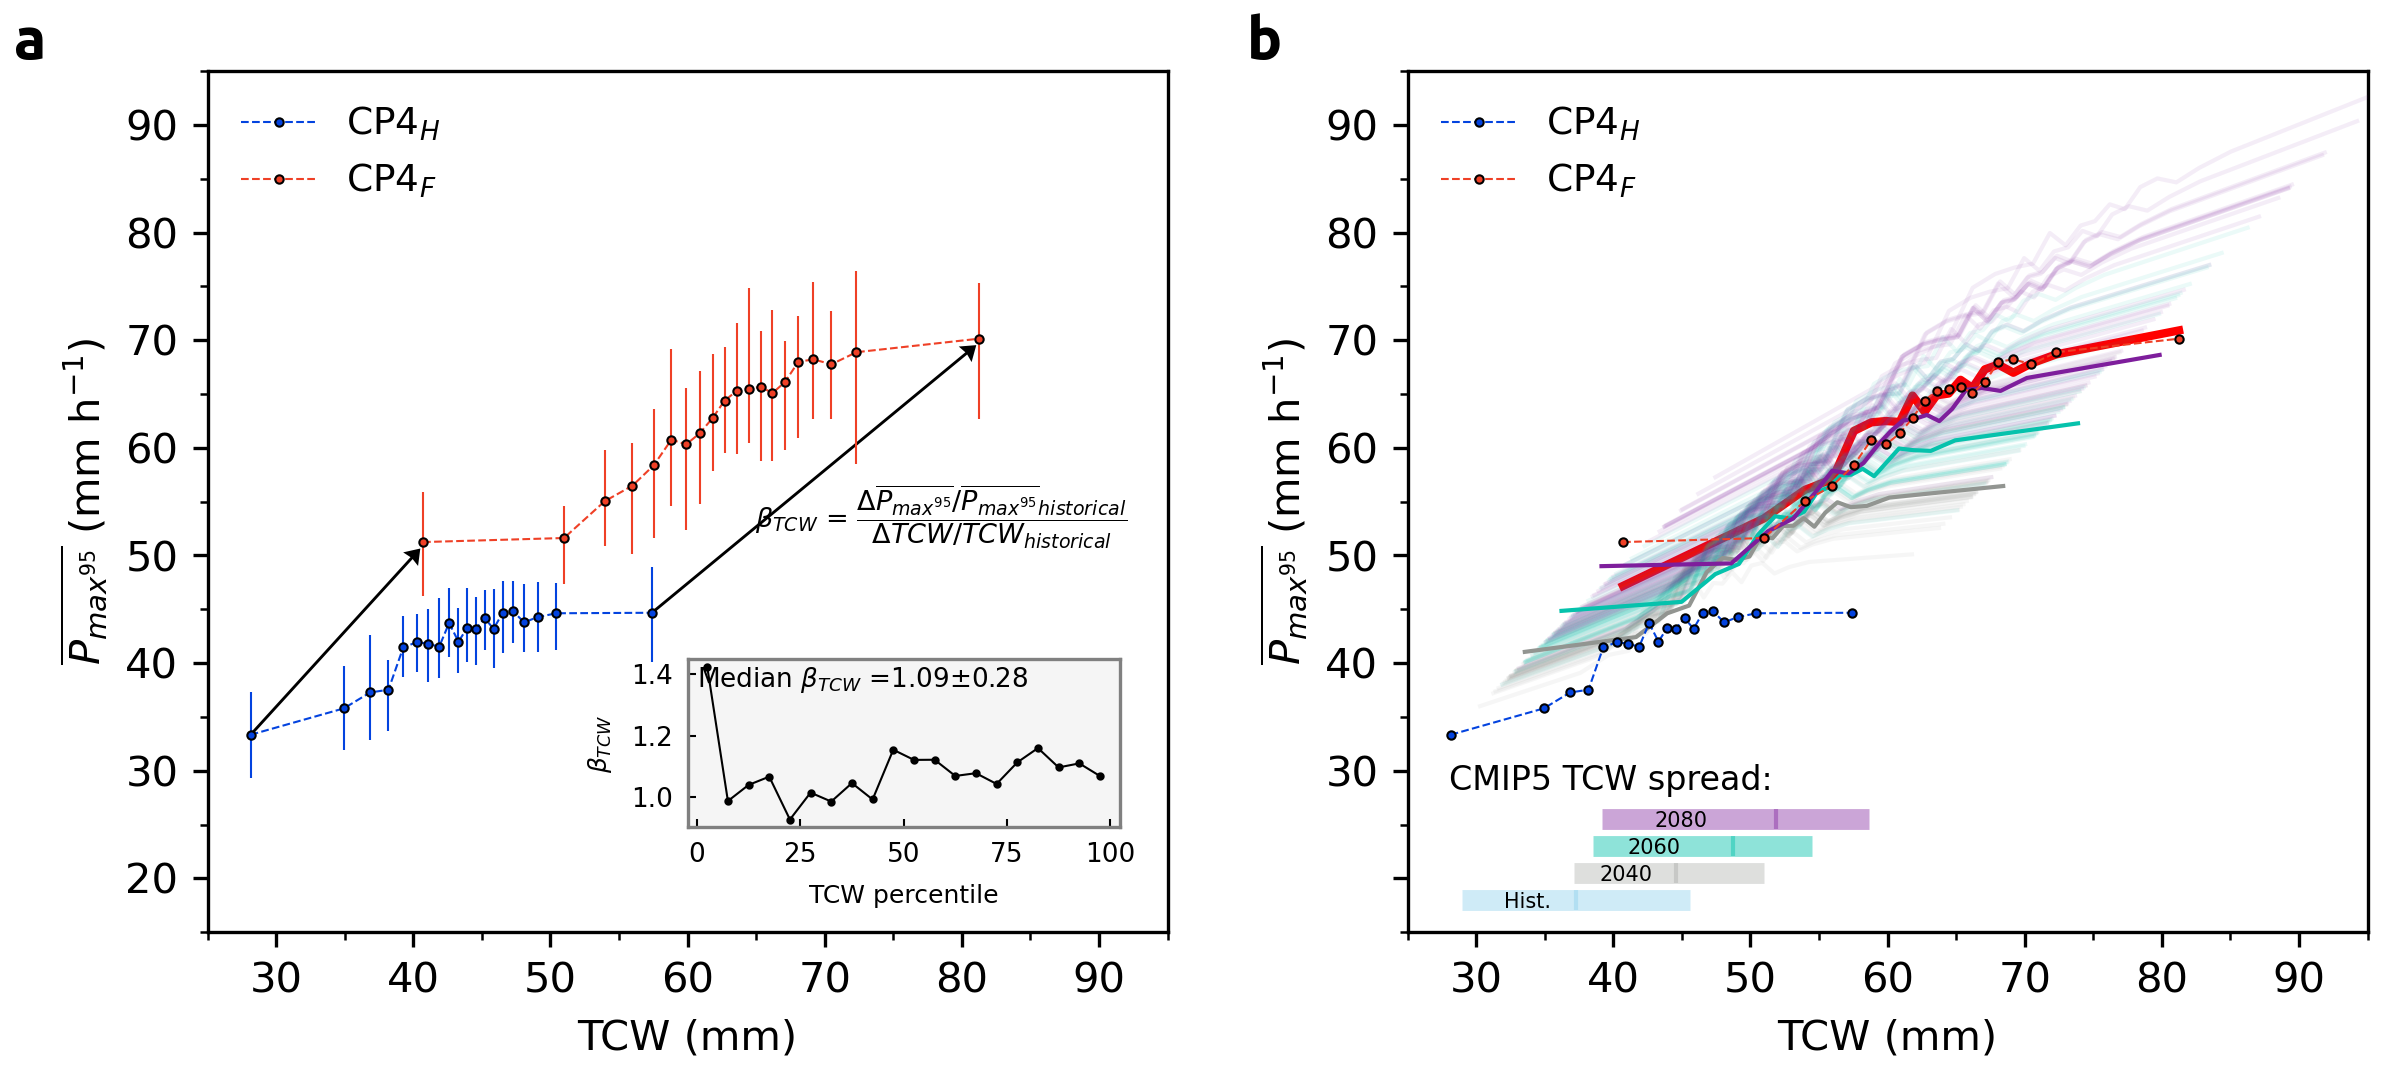

In [253]:
f = plt.figure(figsize=(8,3.5), dpi=300)
widthnorm = 0.40
heightnorm = 0.82
bottomnorm=0.13

left, bottom, width, height = [0.58, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [10.5,13,15.5]
alphas = [0.3,0.45,0.4]
ccolors = ['xkcd:grey', 'xkcd:turquoise', 'xkcd:purple']
dy = 10

#####
spread = ((cmip_read['2040'])['tcw_hist'])
mins = np.min(spread)
maxs = np.max(spread)
median = np.median(spread)
#ipdb.set_trace()
ax.errorbar(np.array(median), np.array(8+dy), xerr=np.array([[median-mins, maxs-median]]).T, color='skyblue', linewidth=5, alpha=0.4, linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)
idss=0
for ids, stry in enumerate(['2040', '2060', '2080']):
    idss += idss+1
    ##########
    spread = ((cmip_read[stry])['tcw_mean'])+((cmip_read[stry])['tcw_hist'])
    mins = np.min(spread)
    maxs = np.max(spread)
    median = np.median(spread)
    #ipdb.set_trace()
    ax.errorbar(np.array(median), np.array(posis[ids]+dy), xerr=np.array([[median-mins, maxs-median]]).T, color=ccolors[ids], linewidth=5, alpha=alphas[ids], linestyle='solid', capthick=0, marker='|', capsize=0, markersize=5)

ax.spines['top'].set_visible(True)
ax.spines['top'].set_linewidth(0.8)


ax.text(28,18.25+dy,'CMIP5 TCW spread:', fontsize=8)
ax.text(32,7.25+dy,'Hist.', fontsize=5)
ax.text(39,9.75+dy,'2040', fontsize=5)
ax.text(41,12.25+dy,'2060', fontsize=5)
ax.text(43,14.75+dy,'2080', fontsize=5)
####

# ax.plot(pcp4['rbins'],pcp4['pmean'], color='mediumblue',  label=r'CP4 historical', linestyle='',marker='o', markersize=3)  #marker='o', markersize=1, #cornflowerblue
# ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', label=r'CP4 future', linestyle='',marker='o', markersize=3) #, marker='o', markersize=1


histline = np.array(pcp4['pmean']) #np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept']))
futline = np.array(pcp4f['pmean']) #np.array(pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])

ax.plot(pcp4['rbins'],histline, color='xkcd:blue', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4$_H$', mfc='xkcd:blue',  marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)
ax.plot(pcp4f['rbins'], futline, color='xkcd:tomato', linestyle='dashed', linewidth=0.5, markersize=2, label='CP4$_F$', mfc='xkcd:tomato', marker='o', markeredgecolor='k', markeredgewidth=0.5, zorder=99)


pick = np.array([0,-1])
ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_yticklabels(['','',30,40,50,60,70,80,90])
ax.legend(loc='upper left', frameon=False, fontsize=9)
coll = []
abss = []
collmm = []

for ids, percs in enumerate(percents):

    ppabs = (futline[ids]-histline[ids])/(pcp4f['rbins'][ids]-pcp4['rbins'][ids])

    aprcp = (futline[ids]-histline[ids])/histline[ids]
    btcw = (pcp4f['rbins'][ids]-pcp4['rbins'][ids])/pcp4['rbins'][ids]
    pperc = aprcp/btcw
    coll.append(pperc)

    abss.append(ppabs)
    
coll = np.array(coll)
abss = np.array(abss)


        
print('Scaling per percentile', coll)
    
for yyinds, yy in enumerate(['2040', '2060', '2080']):
    cmip_rrel = []
    cmip_rel = (cmip_read[yy]['tcw_mean'])/(cmip_read[yy]['tcw_hist'])  #cp4_historical_domainMean #/np.mean(cp4.tcwv)# relative to average MCS tcw ; i.e. if this is the change that ocurrs relative to MCS baseline tcw / compares domain-wide aggregate to domain-wide aggregate
    for crbins in (cmip_read[yy]['tcw_mean']):
        cmip_rrel.append(crbins/np.array(pcp4['rbins']))
    
    cmip_rrel = np.array(cmip_rrel)
    #ipdb.set_trace()
        
    cmip_diff = (cmip_read[yy]['tcw_mean'])

 
    for cinds, cmip_di in enumerate(cmip_rel):
        cmipfut = np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*cmip_di
        cmean = histline+(cmip_di)*1.24*np.array(pcp4['rbins'])
        ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

        
#     for cinds, cmip_di in enumerate(cmip_read[yy]['tcw_mean']):
#         cmipfut = np.array(pcp4['rbins'])+cmip_di
#         cmean = histline+np.array(coll)*(cmip_di) 
#         ax.plot(cmipfut, cmean, color=ccolors[yyinds], linewidth=1, alpha=0.08, markersize=1, zorder=5)

    cmean = histline+histline*(np.mean(cmip_rel))*coll #

    ax.plot(np.array(pcp4['rbins'])+np.array(pcp4['rbins'])*np.mean(cmip_rel), cmean, color=ccolors[yyinds], zorder=95, linewidth=1, alpha=1, markersize=2)
    
# reconstructed CP4 RAINFALL
ax.plot(np.array(pcp4f['rbins']), histline+((pcp4f['rbins']-pcp4['rbins']))*1.1, color='r', linewidth=2)
    
print('Percentage median', np.median(coll))
print('Percentage abs ', np.median(abss))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('$\overline{P_{max^{95}}}$ (mm h$^{-1}$)')


#####################################################################################################################
left, bottom, width, height = [0.08, bottomnorm, widthnorm, heightnorm]
ax = f.add_axes([left, bottom, width, height])
posis = [79,81,83]
alphas = [0.3,0.45,0.6]


ax.plot(pcp4['rbins'],pcp4['pmean'], color='xkcd:blue',  label=r'CP4$_H$', linestyle='dashed',marker='o', markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5)  #marker='o', markersize=1, #cornflowerblue
ax.plot(pcp4f['rbins'],pcp4f['pmean'], color='xkcd:tomato', label=r'CP4$_F$', linestyle='dashed', marker='o',markersize=2, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.5) #, marker='o', markersize=1
ax.errorbar(pcp4['rbins'], pcp4['pmean'], yerr=[np.array(pcp4['pmean'])-np.array(pcp4['p10']),np.array(pcp4['p90'])-np.array(pcp4['pmean'])], color='xkcd:blue', linewidth=0.5, linestyle='')
ax.errorbar(pcp4f['rbins'], pcp4f['pmean'], yerr=[np.array(pcp4f['pmean'])-np.array(pcp4f['p10']),np.array(pcp4f['p90'])-np.array(pcp4f['pmean'])], color='xkcd:tomato', linewidth=0.5, linestyle='')
pick = np.array([0,-1])

yh = (histline)[pick]
xh = pcp4['rbins'][pick]
yf = (futline)[pick]
xf = pcp4f['rbins'][pick]
ax.quiver(xh, yh,(xf)-xh-0.2,yf-yh-0.6, angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=0, headwidth=7, linestyle='dotted')

# ax.plot(pcp4['rbins'],histline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)
# ax.plot(pcp4f['rbins'], futline, color='k', linestyle='dashed', linewidth=0.5,marker='o', markersize=1)


ax.set_xlim(25,95)
ax.set_ylim(15,95)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.legend(loc='upper left', frameon=False, fontsize=9)
ax.text(0.57, 0.47,r'$\beta_{TCW}$ = $\dfrac{\Delta \overline{P_{max^{95}}} / \overline{P_{max^{95}}}_{historical}}{\Delta TCW / TCW_{historical}}$', transform=ax.transAxes, fontsize=6.5) # 0.83



#ax.text(0.58, 0.41,r'$\dfrac{\delta P_{max} 95}{\delta TCW}$: '+str(np.round(np.mean(abss),2))+'$\pm$'+str(np.round(np.std(abss),2))+' mm h$^{-1}$', transform=ax.transAxes, fontsize=6.5)

coll[0] = coll[2]
# fdic = {'rel': coll, 'abs' : abss, 'futslope': pcp4f['rslope'], 'histslope' : pcp4['rslope'], 
#         'futinter' : pcp4f['rintercept'], 'histinter' : pcp4['rintercept'], 'tcw_hist' : pcp4['rbins'], 'prcp_hist' :  pcp4['pmean'], 'tcw_fut' : pcp4f['rbins'], 'prcp_fut' :  pcp4f['pmean']}
# import pickle
# pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "wb"))

ax.set_xlabel(r'TCW (mm)')
ax.set_ylabel('$\overline{P_{max^{95}}}$ (mm h$^{-1}$)')

left, bottom, width, height = [0.28, 0.23, 0.18, 0.16] #[0.275, 0.2, 0.20, 0.27]
ax3 = f.add_axes([left, bottom, width, height])
#ax3.plot(pcp4['bins'], coll, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.plot(percents, abss, color='k', linestyle='solid', linewidth=0.5,marker='o', markersize=1)
ax3.text(0.51, 0.285,r'Median $\beta_{TCW}$ ='+str(np.round(np.median(coll),2))+'$\pm$'+str(np.round(np.max(coll)-np.median(coll),2)), transform=ax.transAxes, fontsize=6.3) # 0.83
ax3.set_xlabel('TCW percentile', fontsize=6)
ax3.set_ylabel(r'$\beta_{TCW}$',fontsize=6)

# ax3.set_xticklabels('')
# ax3.set_yticklabels('')
# ax3.set_xlim(32,62)
# ax3.set_ylim(30,85)

for axis in ['top','bottom','left','right']:
  
  ax3.spines[axis].set_color('grey')
# ax3.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False)
ax3.tick_params(direction='in', length=2, width=0.5, colors='k', labelsize=6.3)
ax3.set_facecolor('whitesmoke')

text = ['a', 'b']
plt.tight_layout()
plt.annotate(text[0], xy=(0.006, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)
plt.annotate(text[1], xy=(0.52, 0.93), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=14)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4_'+ttag+'_TCWV_CMIPscaling_relative_CMIP_9-19N_20masked_beta_0.1mm_new.jpg')